#IMPORTS

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path

In [4]:
import pandas as pd
import numpy as np

In [5]:
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

In [6]:
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import max_norm
from keras import backend as K


In [7]:
import cv2

In [8]:
from skimage.io import imread
from skimage.transform import resize

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [10]:
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

#Data Fetching

In [11]:
#Kaggle Username : prajwalbhandarkar
#Kaggle Key : 74164b06d3aa9376f3fec17a832d135b

In [12]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalbhandarkar
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:25<00:00, 95.5MB/s]


In [13]:
base_dir = Path("chest-xray-pneumonia/chest_xray/chest_xray/")

In [14]:
train_dir = base_dir /"train/"
val_dir = base_dir /"val/"
test_dir = base_dir /"test/"

#Loading Data

In [15]:
os.listdir(train_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [16]:
train_normal_dir = train_dir /"NORMAL" #to set the path to the normals in train set
train_pneumonia_dir = train_dir /"PNEUMONIA" #to set the path to the pneumonias in train set

In [17]:
os.listdir(val_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [18]:
valid_normal_dir = val_dir /"NORMAL" #to set the path to the normals in validation set
valid_pneumonia_dir = val_dir /"PNEUMONIA" #to set the path to the pneumonias in validation set

In [19]:
os.listdir(test_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [20]:
test_normal_dir = test_dir /"NORMAL" #to set the path to the normals in test set
test_pneumonia_dir = test_dir /"PNEUMONIA" #to set the path to the pneumonias in test set

#Labeling

In [21]:
train_normal= train_normal_dir.glob("*.jpeg") #to take the normal images from train set
train_pneumonia=train_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the train set
train_set=[]#to add all the train data into one list, we created a blank list

In [22]:
for img in train_normal: #to add every image of normals in trainset to the list
  train_set.append((img, 0)) #we add 0 with normal images as label
for img in train_pneumonia:#to add every image of pneumonias in trainset to the list
  train_set.append((img, 1)) #we add 1 with pneumonia images as label

In [23]:
print(train_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0629-0001-0003.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0738-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0688-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0703-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0261-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0495-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0533-0001-0002.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0465-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray

In [24]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features

In [25]:
train_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0


In [26]:
train_set=train_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
train_set=train_set.reset_index(drop=True) #to set the indexes as if first time
train_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0


#Setting Data set for validation

In [27]:
valid_normal= valid_normal_dir.glob("*.jpeg") #to take the normal images from validation set
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the validation set
valid_set=[] #to add all the validation data into one list, we created a blank list

In [28]:
for img in valid_normal: #to add every image of normals in validationset to the list
  valid_set.append((img, 0)) #we add 0 with normal images as label
for img in valid_pneumonia:#to add every image of pneumonias in validationset to the list
  valid_set.append((img, 1)) #we add 1 with pneumonia images as label

In [29]:
print(valid_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'), 1), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'),

In [30]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
valid_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [31]:
valid_set=valid_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
valid_set=valid_set.reset_index(drop=True) #to set the indexes as if first time
valid_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [32]:
test_normal= test_normal_dir.glob("*.jpeg") #to take the normal images from test set
test_pneumonia=test_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the test set
test_set=[]#to add all the test data into one list, we created a blank list


In [33]:
for img in test_normal: #to add every image of normals in test set to the list
  test_set.append((img, 0)) #we add 0 with normal images as label
for img in test_pneumonia:#to add every image of pneumonias in test set to the list
  test_set.append((img, 1)) #we add 1 with pneumonia images as label

In [34]:
print(test_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0348-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0305-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0374-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0028-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0370-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0084-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0012-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0010-0001.jpeg'), 0), (PosixPath('che

In [35]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
test_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


In [36]:
test_set=test_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
test_set=test_set.reset_index(drop=True) #to set the indexes as if first time
test_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


#Visualization

In [37]:
# Normal Image
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [38]:
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


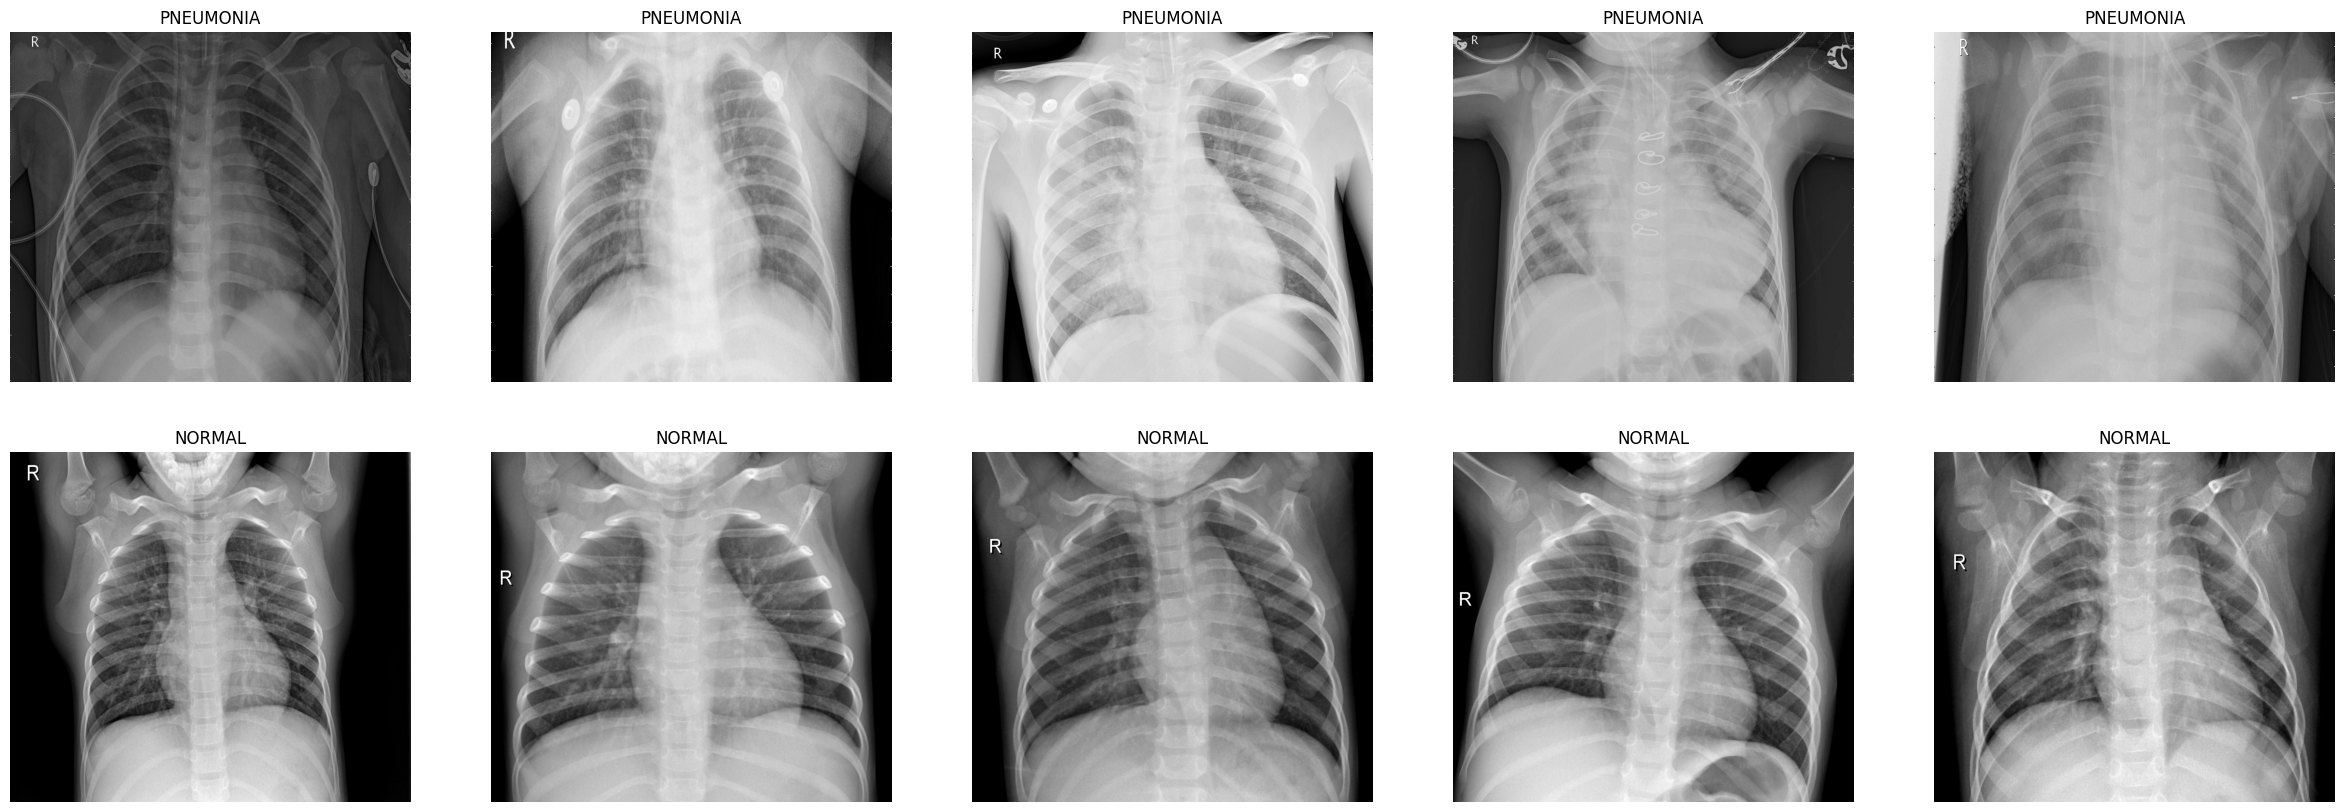

In [39]:
# Get few samples for both the classes
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

# Concate the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

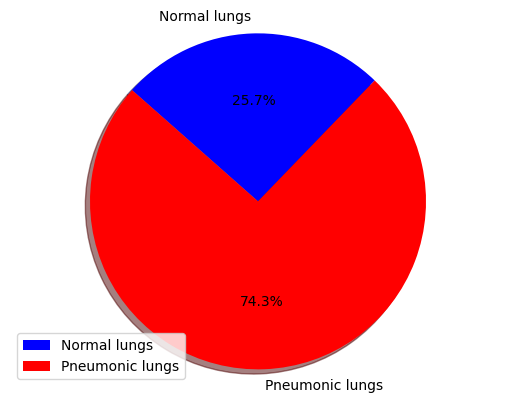

In [40]:
fig1,ax1= plt.subplots()
sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

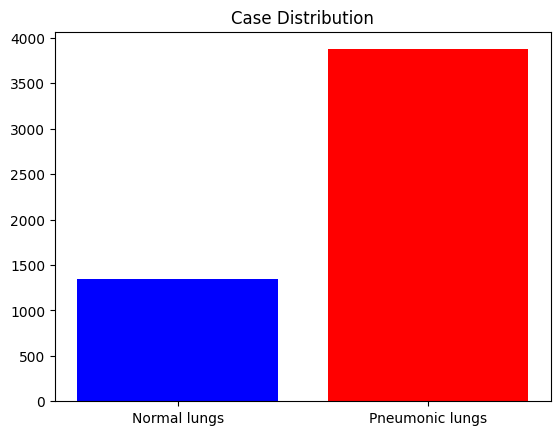

In [41]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")

#Data Preparation
##Data Distribution

In [42]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [43]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [44]:
# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

#Data Normalization

In [45]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [46]:
#Reshaping Data
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#DATA AUGMENTATION

In [47]:
# normalize and augment images
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images

image_generator.fit(X_train)

#Data Modelling

In [48]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [49]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [50]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])


Epoch 1/15
183/183 [==============================] - 560s 3s/step - loss: 0.5430 - accuracy: 0.8381 - val_loss: 8.7416 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 552s 3s/step - loss: 0.2810 - accuracy: 0.8941 - val_loss: 3.1519 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 571s 3s/step - loss: 0.2304 - accuracy: 0.9138 - val_loss: 1.6950 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 568s 3s/step - loss: 0.2197 - accuracy: 0.9238 - val_loss: 0.2185 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - 549s 3s/step - loss: 0.2005 - accuracy: 0.9300 - val_loss: 1.7543 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 6/15
183/183 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9361
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
183/183 [==============================] - 520s 

In [51]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

183/183 [==============================] - 113s 609ms/step - loss: 0.1651 - accuracy: 0.9471
Loss of the model is -  0.16506297886371613
183/183 [==============================] - 104s 570ms/step - loss: 0.1651 - accuracy: 0.9471
Accuracy of the model is -  94.70628499984741 %


In [ ]:
model.save('pneumonia_classifier.h5')

#Evaluation

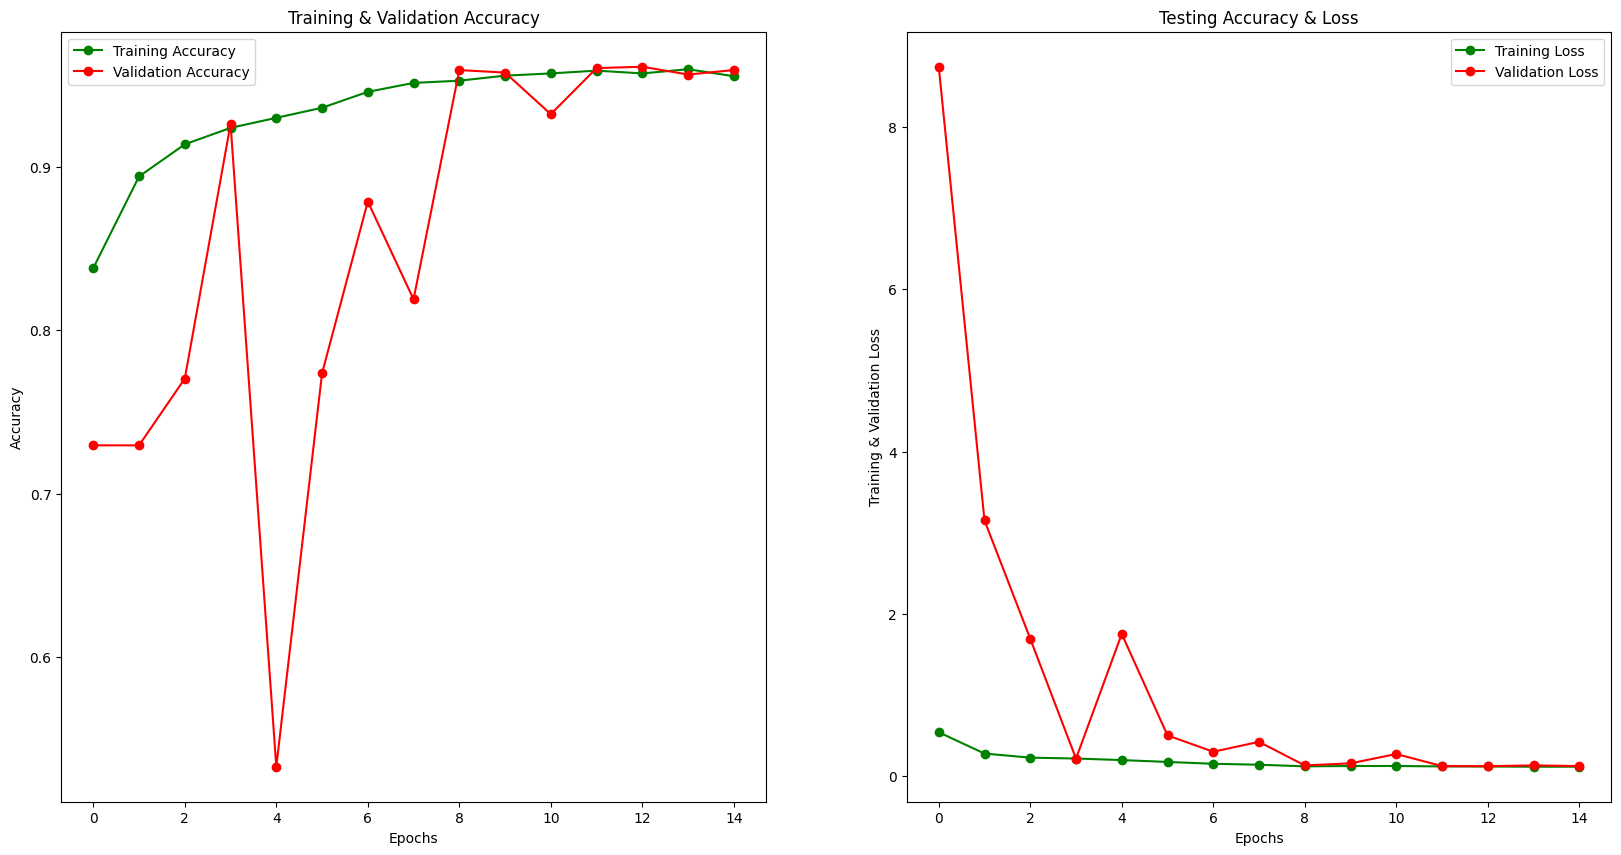

In [53]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()